In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pmesh import ParticleMesh
from cosmoprimo.fiducial import DESI
from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction, setup_logging
from mockfactory import EulerianLinearMock, LagrangianLinearMock, RandomBoxCatalog, setup_logging
from pypower.fft_power import project_to_basis

from densitysplit import catalog_data, density_split

## General parameters

In [2]:
# Data and output directories
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8
catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
#catalog.shift_boxcenter(-catalog.offset)
z = catalog.redshift

# Density mesh
cellsize = 10
resampler = 'tsc'
nsplits = 3

# Correlation function
randoms_size = 4
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))
los = 'x'

# Mocks
nmesh = 512
nbar = catalog.size/catalog.boxsize**3
boxsize = catalog.boxsize
boxcenter = catalog.boxcenter

# For RSD
cosmology = fiducial.AbacusSummitBase()
bg = cosmology.get_background()
f = bg.growth_rate(catalog.redshift)

## Theoretical linear 2PCF

In [3]:
cosmo = cosmology
pk_interp = cosmo.get_fourier().pk_interpolator().to_1d(z=z)

# Generate P(k) on the mesh
pm = ParticleMesh(BoxSize=[boxsize] * 3, Nmesh=[nmesh] * 3, dtype='f8')
cfield = pm.create('complex')
norm = bias**2 / pm.BoxSize.prod()
for kslab, delta_slab in zip(cfield.slabs.x, cfield.slabs):
    # The square of the norm of k on the mesh
    k2 = sum(kk**2 for kk in kslab)
    k = (k2**0.5).ravel()
    mask_nonzero = k != 0.
    pk = np.zeros_like(k)
    pk[mask_nonzero] = pk_interp(k[mask_nonzero])
    delta_slab[...].flat = pk * norm
    
xifield = cfield.c2r()  # Xi(s)
s, mu, xi = project_to_basis(xifield, edges=(np.linspace(0., 200., 51), np.array([-1., 1.])), exclude_zero=True)[0][:3]
s, xi = s.ravel(), xi.ravel()

In [5]:
pm.BoxSize

array([1000., 1000., 1000.])

In [6]:
test = np.array([[1, 2, 3], [4, 5, 6]])

In [10]:
(np.sinc(test / 2. / np.pi)).prod(1)

array([0.53654947, 0.00511973])

## 2PCF calculated from mock density mesh

In [15]:
def damping_function(k, kN):
    k_lambda=0.8*kN
    sigma_lambda=0.05*kN

    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [16]:
# Generate mock
pklin = cosmology.get_fourier().pk_interpolator().to_1d(z)

kN = np.pi*nmesh/boxsize

k=np.logspace(-5, 2, 1000000)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk, kN) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

# unitary_amplitude forces amplitude to 1
mock = EulerianLinearMock(pkdamped, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=0, unitary_amplitude=True)

mock.set_real_delta_field(bias=bias)
mock_rfield = mock.mesh_delta_r
mock_cfield = mock_rfield.r2c()
mock_cfield[...] = mock_cfield[...] * mock_cfield[...].conj()  # P(k)
mock_xifield = mock_cfield.c2r()  # Xi(s)
mock_s, mock_mu, mock_xi = project_to_basis(mock_xifield, edges=(np.linspace(0., 200., 51), np.array([-1., 1.])), exclude_zero=True)[0][:3]
mock_s, mock_xi = mock_s.ravel(), mock_xi.ravel()

## Plot

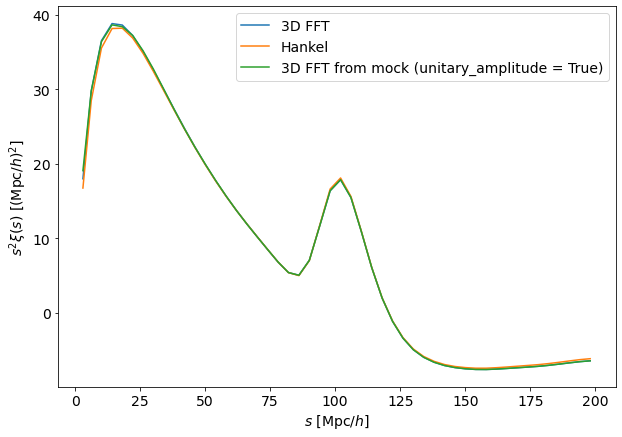

In [17]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 14})

if xifield.pm.comm.rank == 0:
    from matplotlib import pyplot as plt
    plt.plot(s, s**2 * xi, label='3D FFT')
    xi_interp = pk_interp.to_xi()
    plt.plot(s, s**2 * bias**2 * xi_interp(s), label='Hankel')
    plt.plot(mock_s, mock_s**2 * mock_xi, label='3D FFT from mock (unitary_amplitude = True)')
    plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
    plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    plt.legend()
    plt.show()